In [1]:
import os
import random
from datetime import datetime
import ast
import math

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from preprocessing.revolution_preprocessing import serve_data

from models.context_unet import ContextUnet

import ddpm.cu_ddpm as ddpm

from evaluation.pca_tsne import visualize_pca_tsne_unet
from evaluation.jsd import compute_jsd

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [3]:
config_path = "./config.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])
img_rows = int(config["img_rows"])
img_cols = int(config["img_cols"])
channels = int(config["channels"])
n_feat = int(config["n_feat"])

assert model_name in ["ContextUnet"], "Chosen  model was not valid, the option is ContextUnet"
assert cond_model in {"mlp", "te", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te and stft"


log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

In [4]:
timesteps, betas, batch_size_config, epochs, lr

(500, (0.0001, 0.02), 10, 2, 0.001)

### Model params
timesteps = 500
beta1 = 1e-4
beta2 = 0.02
batch_size = 10
n_epoch = 500
lrate=1e-3

# Data

In [5]:
#Can take a while to load
train_loader, test_loader, n_cfeat, customer_ids = serve_data(batch_size_config)

loading meter data
train_data shape: (33752, 1, 64, 64)
test_data shape: (8439, 1, 64, 64)
loading condition data
train_data shape: (33752, 9)
test_data shape: (8439, 9)
loading customer ids


# Model

In [6]:
model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=img_cols, cond_model=cond_model).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter(tb_writer)

## DDPM

# Train

In [7]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

lowest_loss = 100000
step=0

model.train()
for ep in tqdm(range(epochs)):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lr*(1-ep/epochs)

    epoch_loss = 0.0   # initialize epoch loss
    for i, (x, c) in enumerate(train_loader):   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        noise = noise.type(torch.float32)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = ddpm.perturb_input(x, t, noise, beta1=betas[0], beta2=betas[1], timesteps=timesteps, device=device)

        # use network to recover noise
        time = t / timesteps
        time = time.type(torch.float32)
        x_pert = x_pert.type(torch.float32)
        c = c.type(torch.float32)
        
        pred_noise = model(x_pert, time, c=None)
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1
    
    if i%len(train_loader)== 0 and ep %10==0:
        print(f'Epoch: {ep+1}, Loss: {loss.item()}')
        
    print(f'Epoch: {ep+1}, Loss: {loss.item()}')
    
    if ep % save_rate == 0:
        torch.save({
            'epoch': ep+1,
            'diffusion_state_dict': model.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'{ep}_weights.pth'))
    
torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 0


 50%|█████     | 1/2 [01:33<01:33, 93.70s/it]

Epoch: 1, Loss: 0.3540689945220947
epoch 1


100%|██████████| 2/2 [03:08<00:00, 94.40s/it]

Epoch: 2, Loss: 0.34428417682647705


# Sampling

In [8]:
def plot_samples(sample, rows=None, cols=None, figsize=(12, 10), title=None):
    n_images = sample.shape[0]
    
    if rows is None and cols is None:
        cols = math.ceil(math.sqrt(n_images))
        rows = math.ceil(n_images / cols)
    elif rows is None:
        rows = math.ceil(n_images / cols)
    elif cols is None:
        cols = math.ceil(n_images / rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    if rows > 1 or cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  
    
    for i in range(n_images):
        if i < len(axes):  
            im = axes[i].imshow(sample[i], cmap='viridis')
            axes[i].set_title(f'Image {i+1}')
            axes[i].axis('off')  
    
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

In [9]:
sample, _ = ddpm.sample_ddpm_context(n_sample=10, context=None, channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
sample = sample.cpu().numpy()
sample = sample.squeeze()

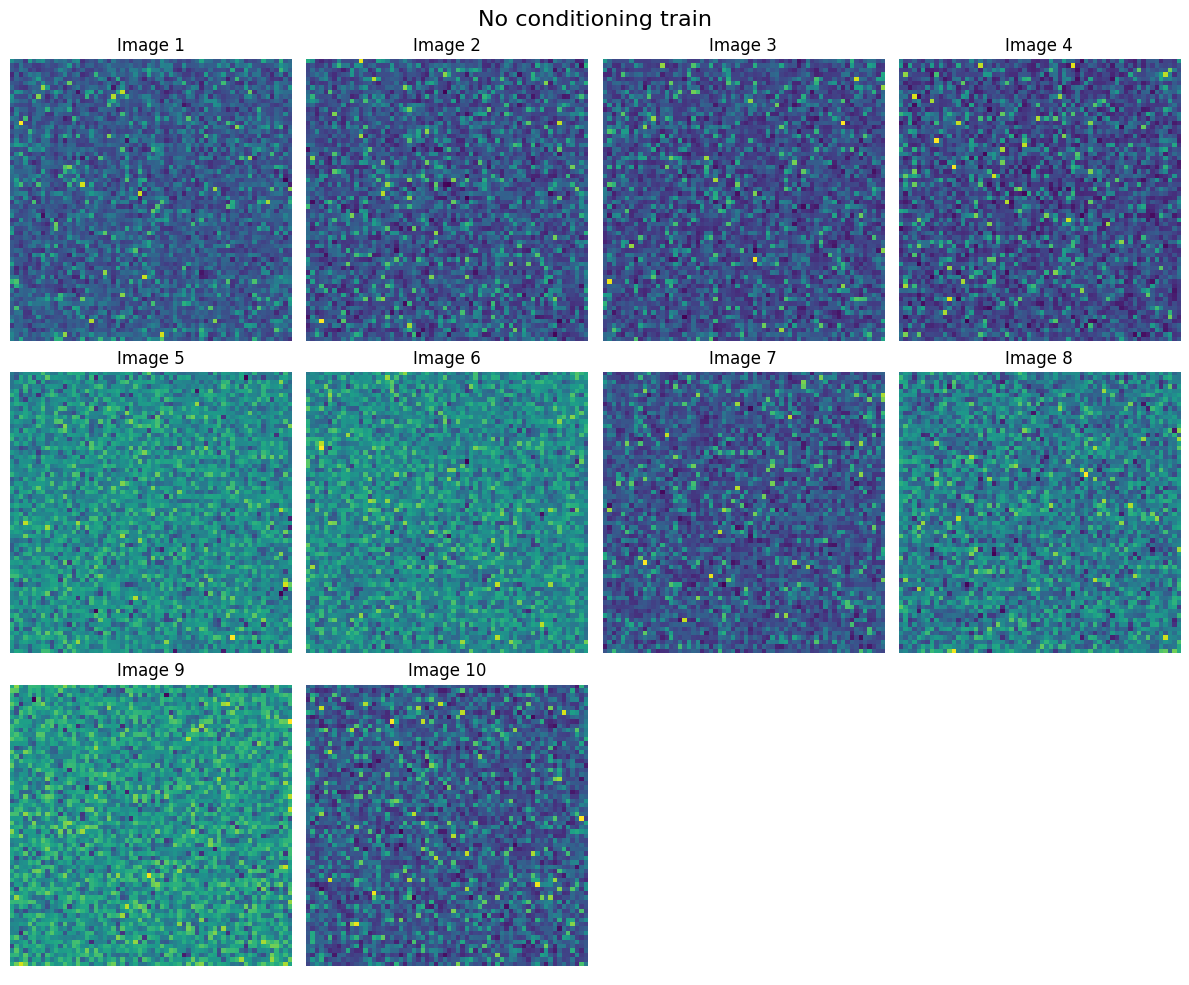

In [10]:
plot_samples(sample, title="No conditioning train")

# Evaluation
## Without Conditioning
### Train

In [11]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([10, 9]), torch.Size([10, 1, 64, 64]))

In [12]:
selected_customer_ids = random.sample(range(len(customer_ids)), 5)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


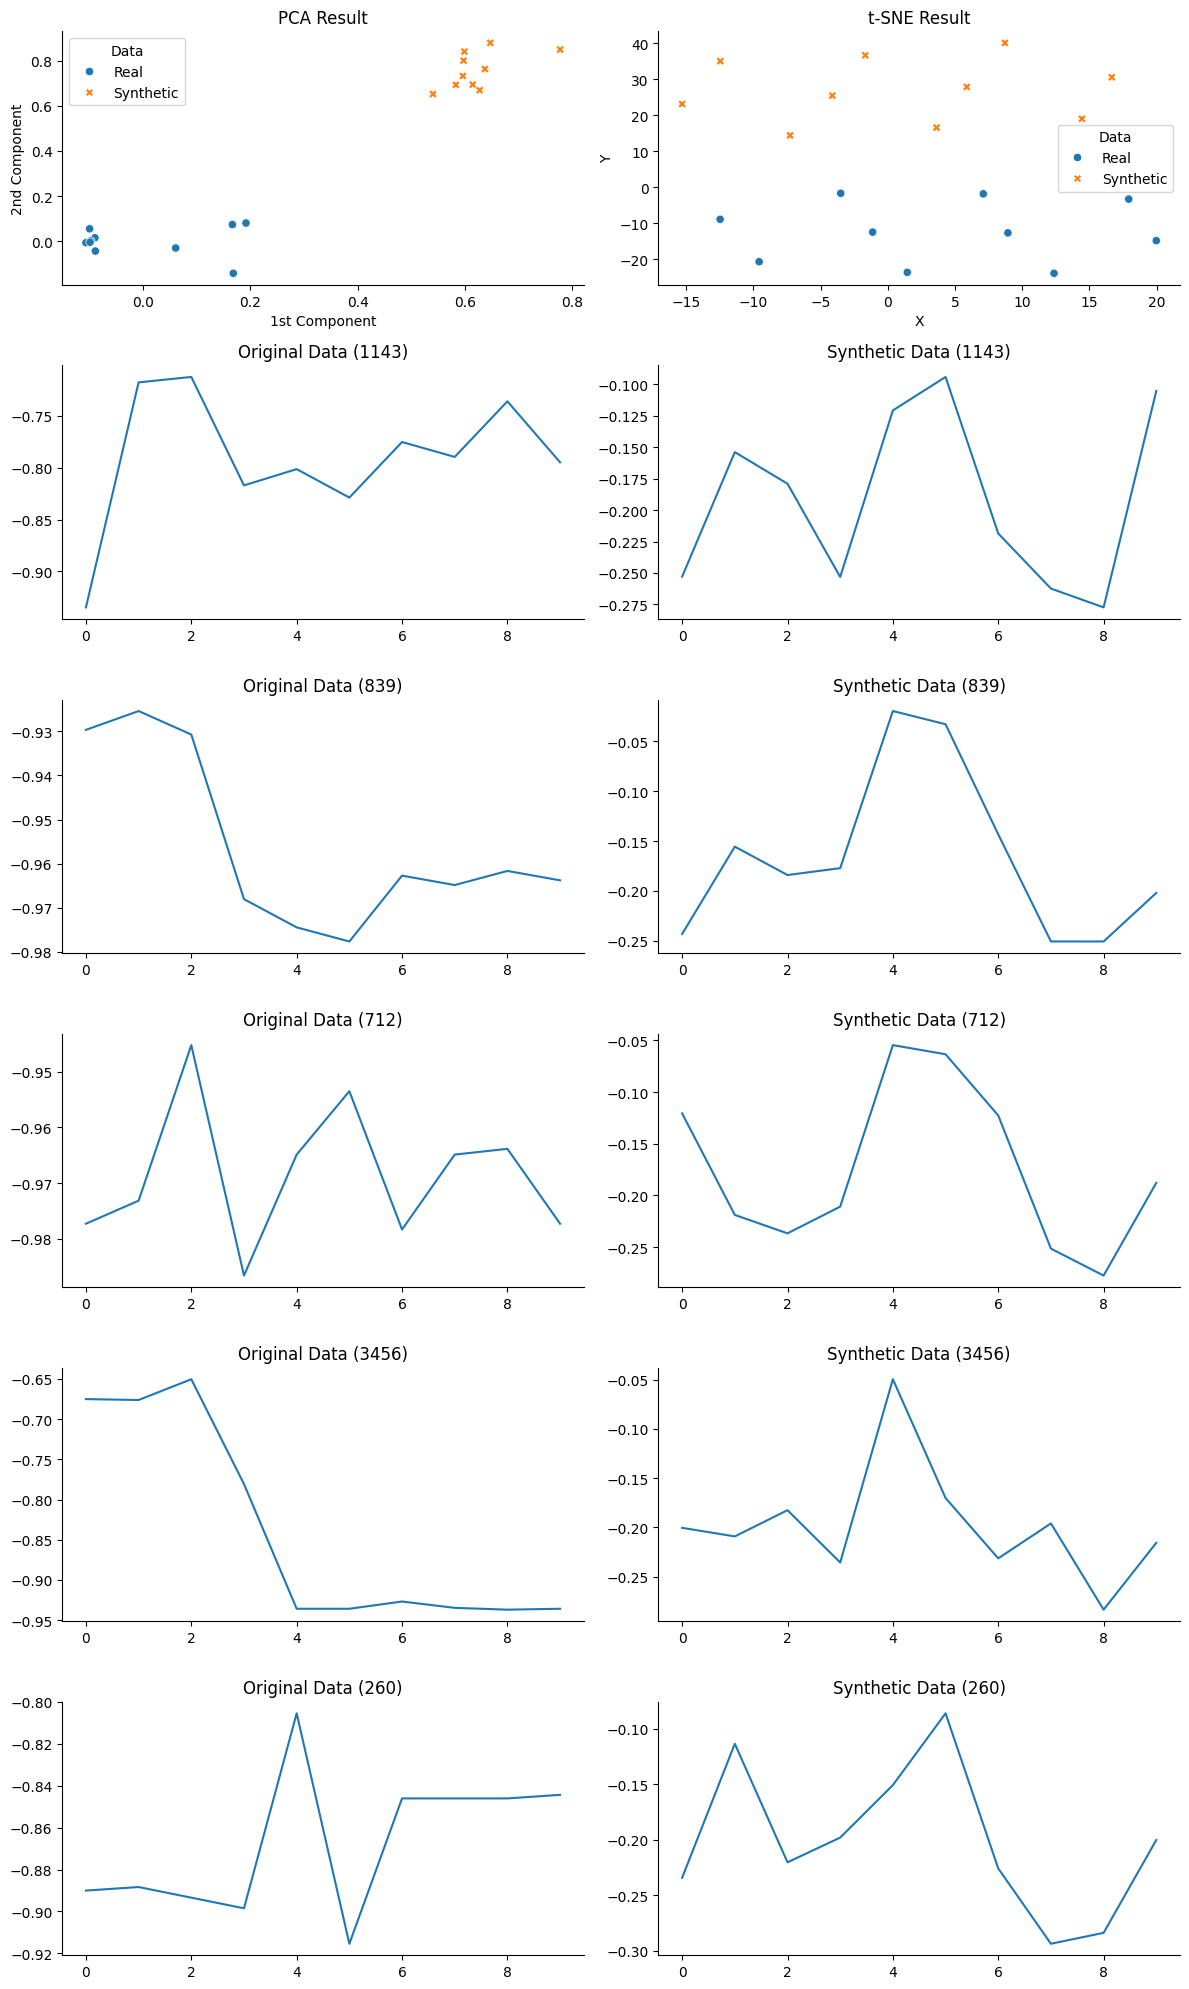

In [13]:
visualize_pca_tsne_unet(real_data_train, sample, customer_ids, filename=log_file_name)

In [14]:
jsd_train_no_cond = {}
multi_customer_sample = sample.reshape(-1, img_cols*img_rows)
multi_customer_real_data = real_data_train.reshape(-1, img_cols*img_rows)

for i in range(multi_customer_sample.shape[1]):
    jsd_train_no_cond[i] = compute_jsd(multi_customer_real_data[:, i], multi_customer_sample[:, i])

### Test

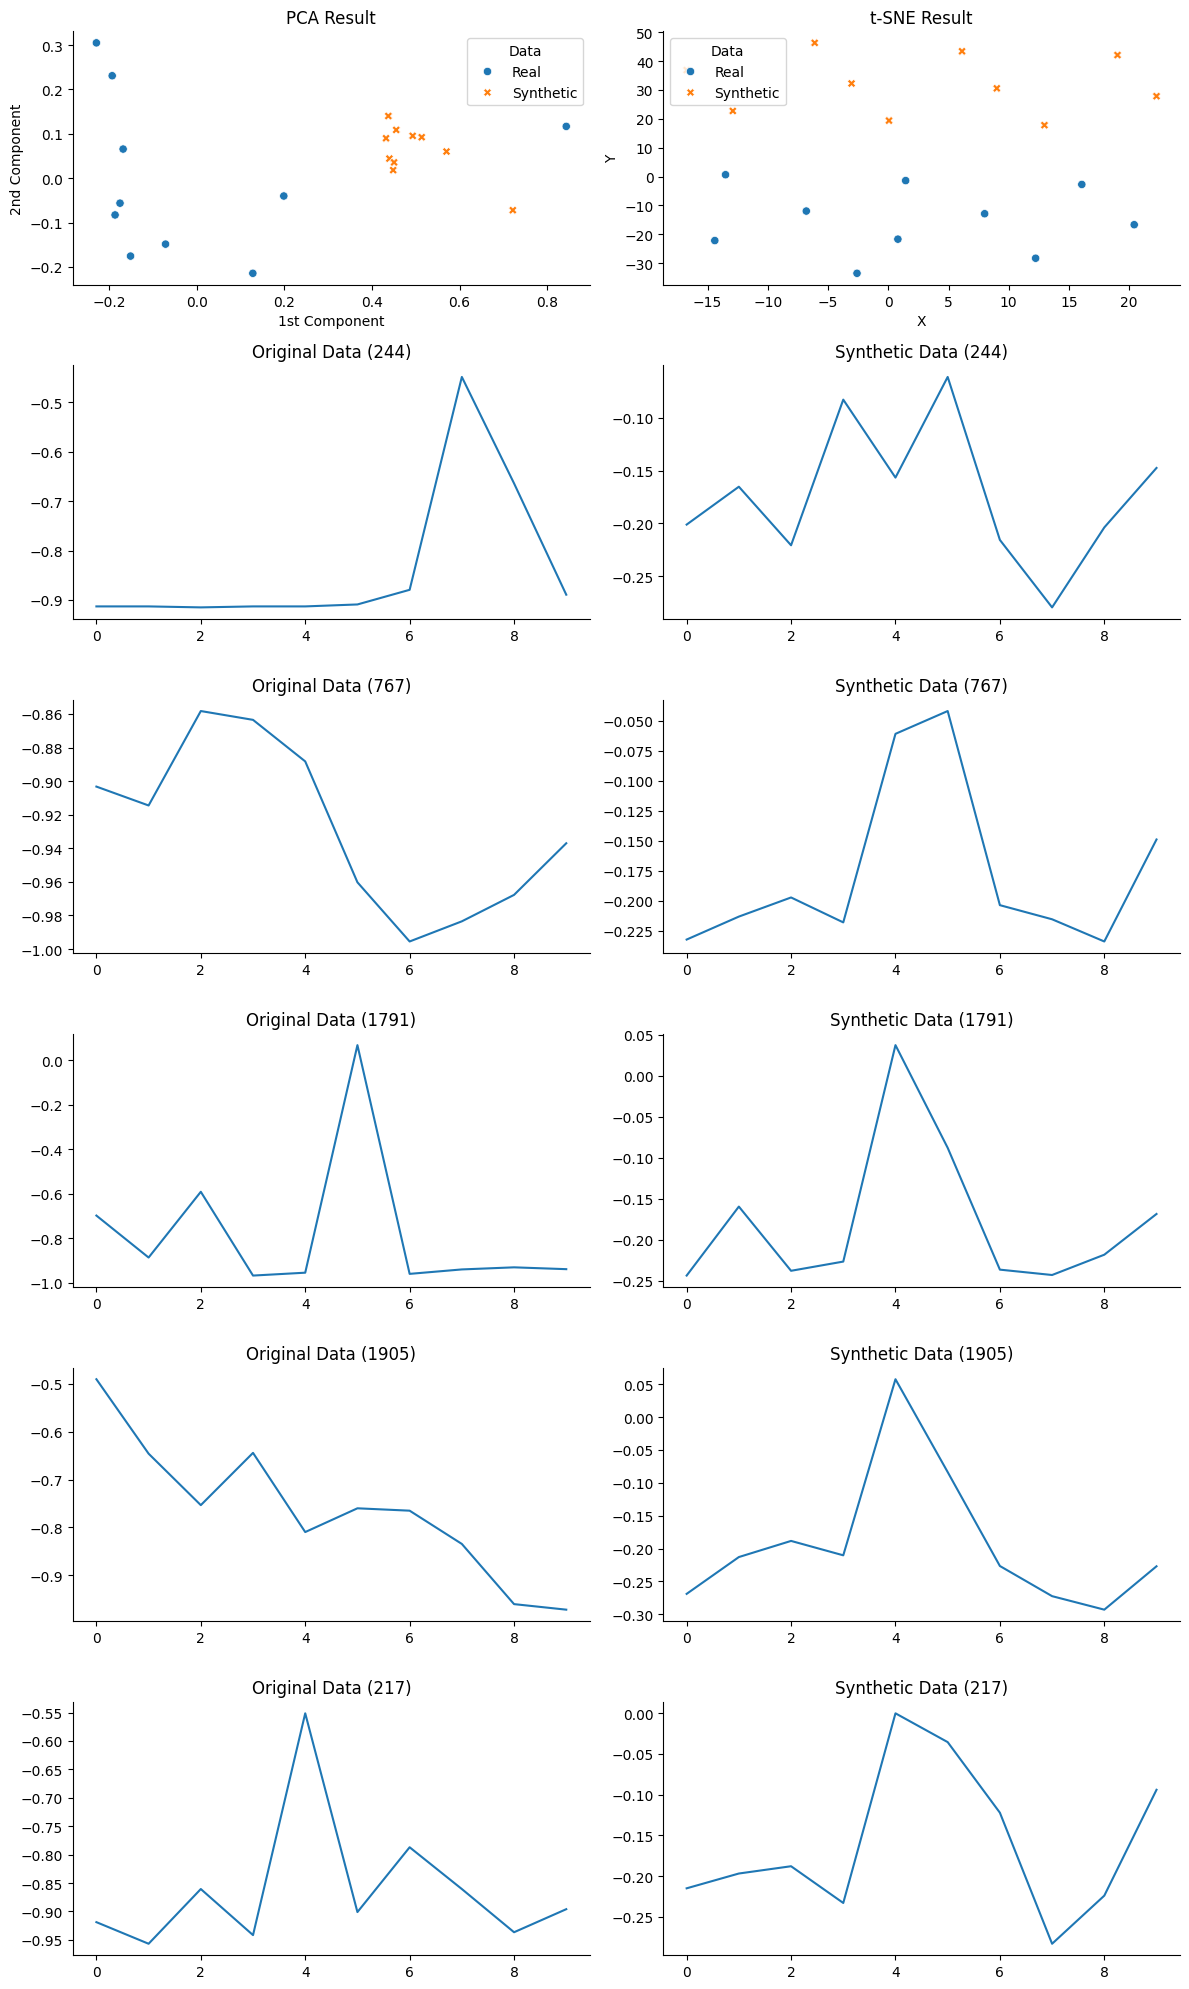

In [15]:
visualize_pca_tsne_unet(real_data_test, sample, customer_ids, filename=log_file_name, train_test="Test")

In [16]:
jsd_test_no_cond = {}
multi_customer_sample = sample.reshape(-1, img_cols*img_rows)
multi_customer_real_data = real_data_test.reshape(-1, img_cols*img_rows)

for i in range(multi_customer_sample.shape[1]):
    jsd_test_no_cond[i] = compute_jsd(multi_customer_real_data[:, i], multi_customer_sample[:, i])

## With Conditioning
### Train

In [17]:
sample, _ = ddpm.sample_ddpm_context(n_sample=10, context=real_cond_data_train.to(device), channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
sample = sample.cpu().numpy()
sample = sample.squeeze()

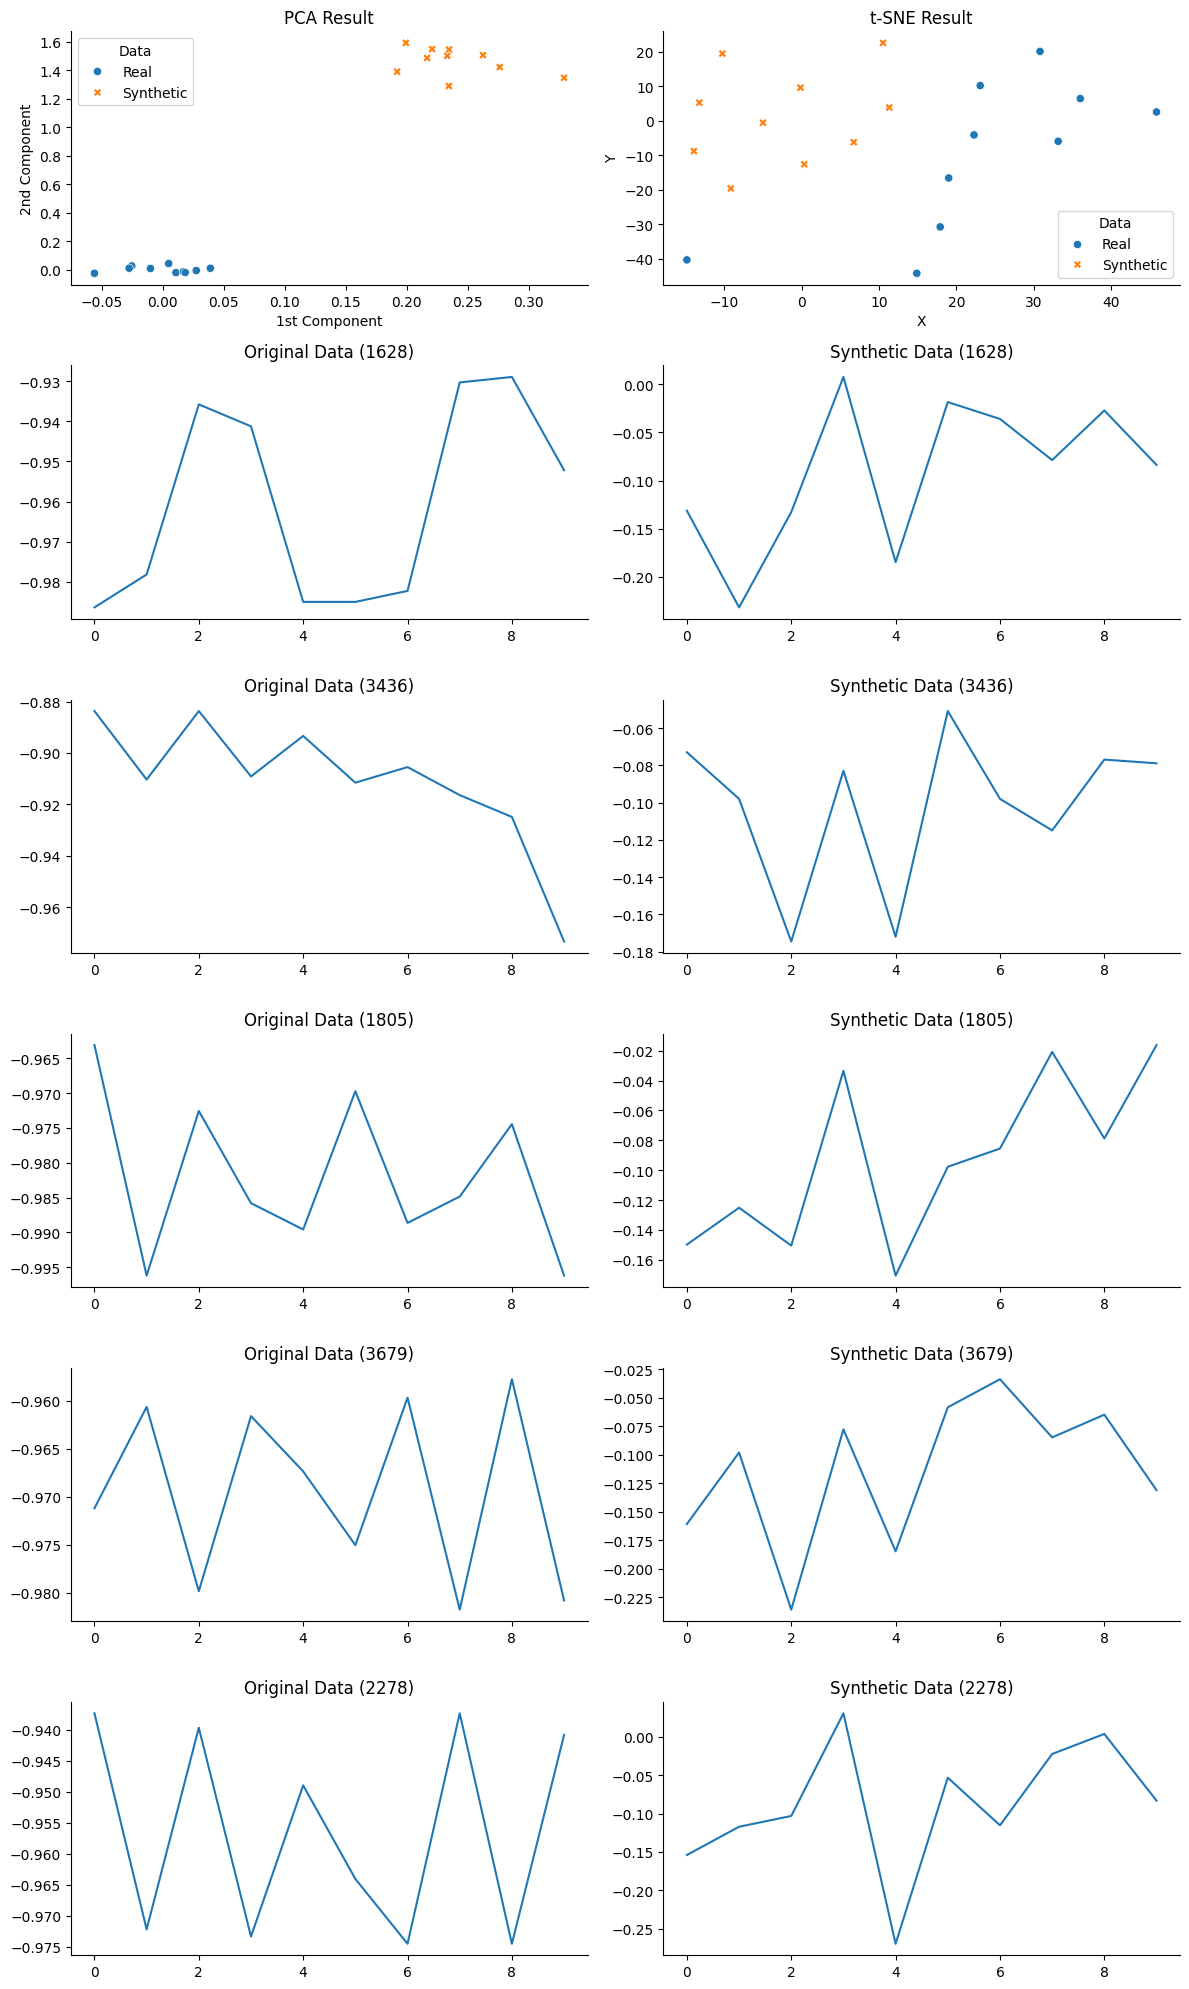

In [18]:
visualize_pca_tsne_unet(real_data_train, sample, customer_ids, filename=log_file_name, cond=True)

In [ ]:
jsd_train_cond = {}
multi_customer_sample = sample.reshape(-1, img_cols*img_rows)
multi_customer_real_data = real_data_train.reshape(-1, img_cols*img_rows)

for i in range(multi_customer_sample.shape[1]):
    jsd_train_cond[i] = compute_jsd(multi_customer_real_data[:, i], multi_customer_sample[:, i])

### Test

In [20]:
sample, _ = ddpm.sample_ddpm_context(n_sample=10, context=real_cond_data_test.to(device), channels=channels, height=img_cols, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
sample = sample.cpu().numpy()
sample = sample.squeeze()

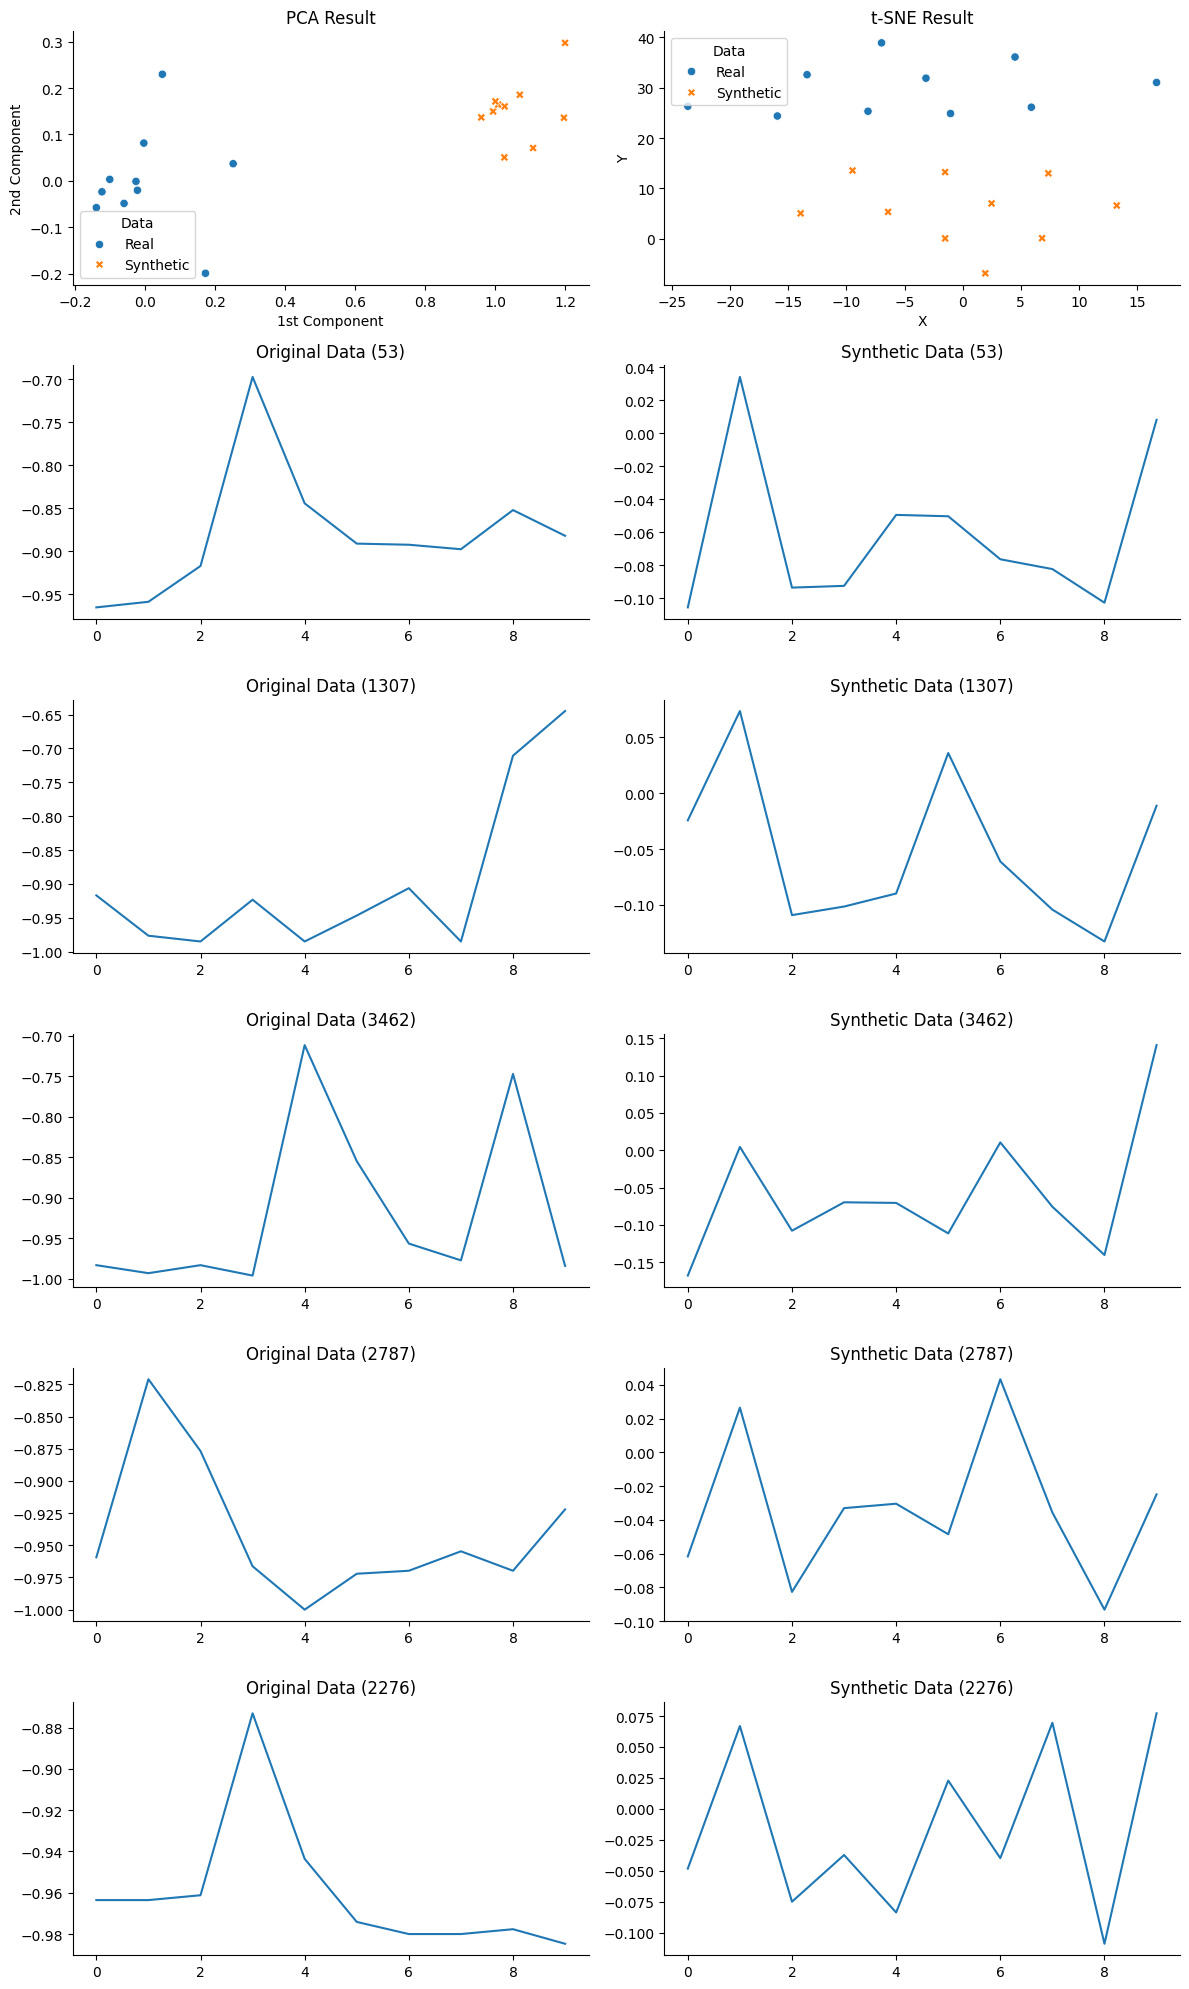

In [21]:
visualize_pca_tsne_unet(real_data_test, sample, customer_ids, filename=log_file_name, cond=True, train_test="Test")

In [22]:
jsd_test_cond = {}
multi_customer_sample = sample.reshape(-1, img_cols*img_rows)
multi_customer_real_data = real_data_test.reshape(-1, img_cols*img_rows)

for i in range(multi_customer_sample.shape[1]):
    jsd_test_cond[i] = compute_jsd(multi_customer_real_data[:, i], multi_customer_sample[:, i])

In [50]:
jsd_train_no_cond.values()

dict_values([0.7745917227656404, 0.8730721832269593, 0.7745995021867726, 0.7242316750206969, 0.8730726645780151, 0.6798938209353689, 0.8396633328953147, 0.8366600998421978, 0.8137868072006992, 0.8366600139155641, 0.8944311327351644, 0.8944272345832959, 0.7746048293279887, 0.8137953746471084, 0.8944245001100687, 0.8944261125974776, 0.8366523908795437, 0.894427359485273, 0.8366594308513963, 0.787094467210862, 0.8944332478697858, 0.8396384787363977, 0.8366613060932631, 0.7745965968980325, 0.8944332643533961, 0.8730725078660887, 0.8944296246897193, 0.8366599578974301, 0.8730781944174438, 0.8944272784055038, 0.8944260158599717, 0.8944271231272531, 0.8944332720317377, 0.8589202445772917, 0.7902477340778835, 0.8366577312012071, 0.6515450904841442, 0.8137908975233298, 0.8137955485492984, 0.8944254113399245, 0.8366597184047302, 0.8366615632360517, 0.8137906174165914, 0.8944269326410652, 0.7825808908456281, 0.8944271909999157, 0.8366575186194166, 0.8366594064321672, 0.894427954492967, 0.85892030

In [ ]:
jsd_data = pd.DataFrame({
    'Train No Cond': jsd_train_no_cond,
    'Test No Cond': jsd_test_no_cond,
    'Train Cond': jsd_train_cond,
    'Test Cond': jsd_test_cond
})

all_keys = set(jsd_train_no_cond.keys()) | set(jsd_test_no_cond.keys()) | set(jsd_train_cond.keys()) | set(jsd_test_cond.keys())

jsd_data = pd.DataFrame({
    'Train No Cond': [jsd_train_no_cond.get(k, None) for k in all_keys],
    'Test No Cond': [jsd_test_no_cond.get(k, None) for k in all_keys],
    'Train Cond': [jsd_train_cond.get(k, None) for k in all_keys],
    'Test Cond': [jsd_test_cond.get(k, None) for k in all_keys]
}, index=list(all_keys))

,Train No Cond,Test No Cond,Train Cond,Test Cond
0,0.774592,0.851182,0.851179,0.894427
1,0.873072,0.749837,0.894427,0.873073
2,0.774600,0.774597,0.836662,0.836660
3,0.724232,0.873073,0.894427,0.836660
4,0.873073,0.813791,0.813791,0.873073


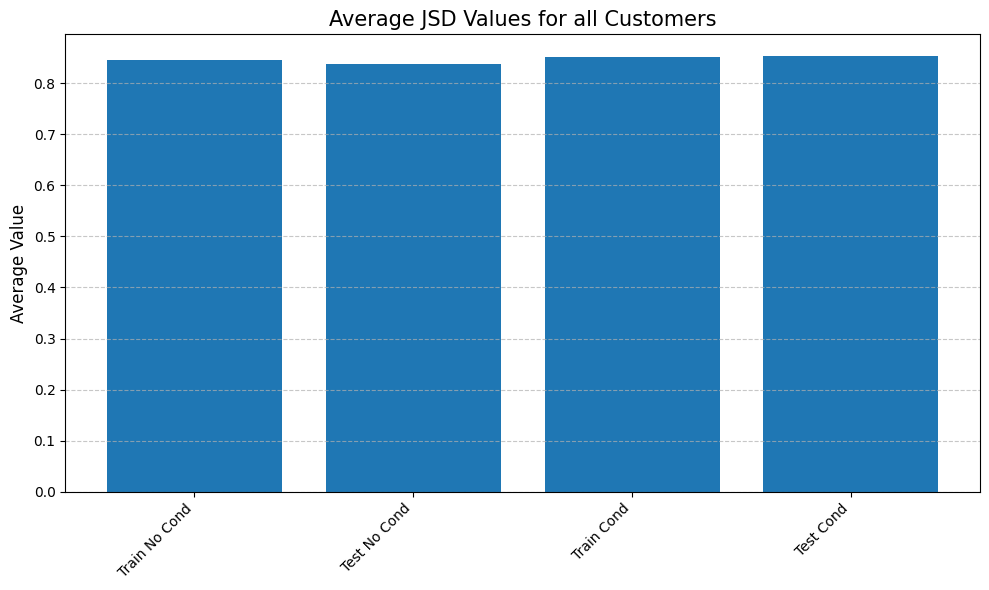

In [56]:
plot_dir = f'./logging/plots/JSD/'

if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)


means = jsd_data.mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(means.index, means.values)

plt.title('Average JSD Values for all Customers', fontsize=15)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, log_file_name+".png", ))
plt.show()

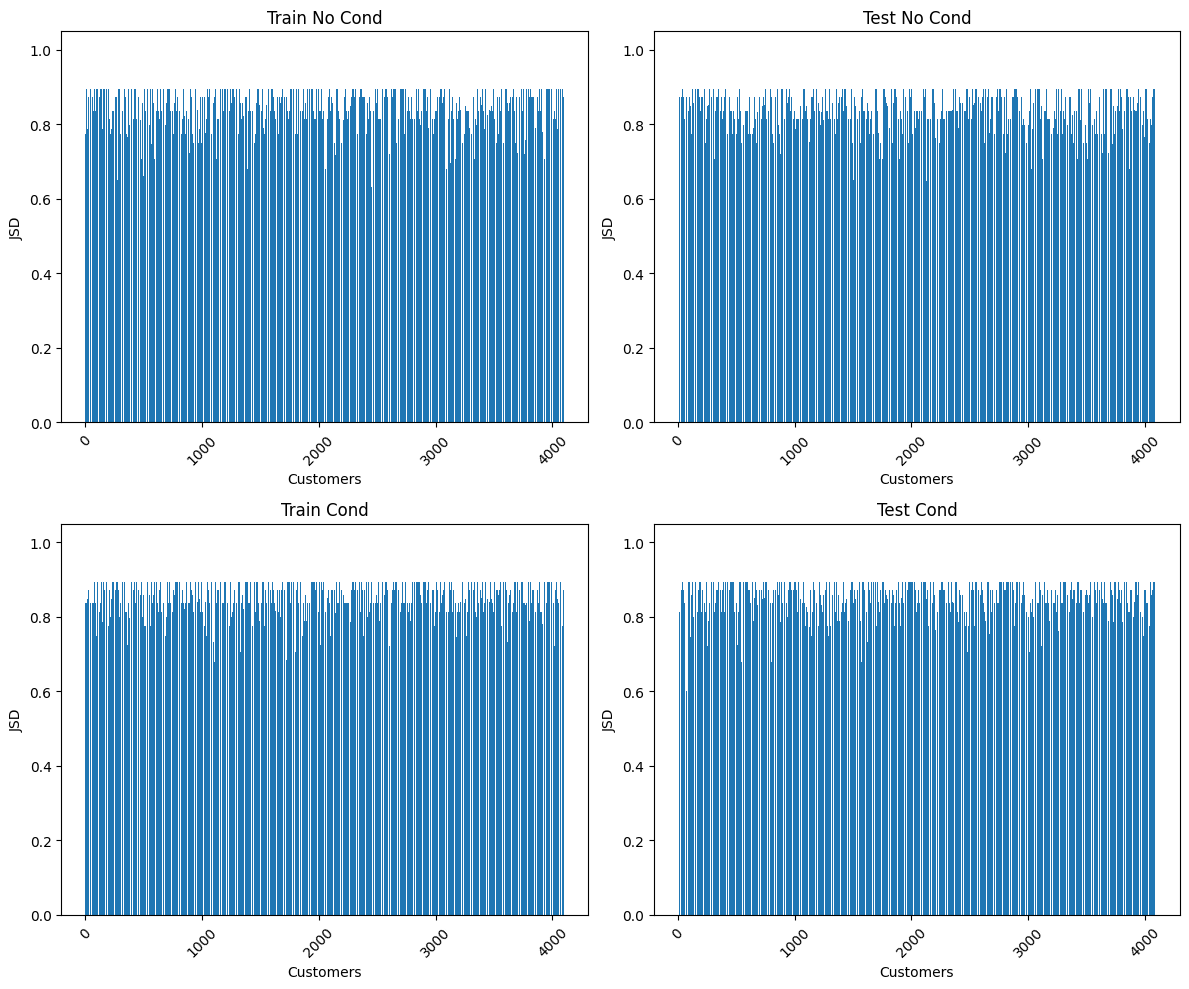

In [ ]:
# plot_dir = f'./logging/plots/JSD/'

# if not os.path.exists(plot_dir):
#         os.makedirs(plot_dir)

# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
# axs = axs.flatten()

# for i, column in enumerate(jsd_data.columns):
#     axs[i].bar(jsd_data.index, jsd_data[column])
#     axs[i].set_title(column)
#     axs[i].set_xlabel('Customers')
#     axs[i].set_ylabel('JSD')
#     axs[i].tick_params(axis='x', rotation=45)

# plt.tight_layout()
# plt.savefig(os.path.join(plot_dir, log_file_name+".png", ))
# plt.show()